<p style='margin:0in'><b><span style='font-size:36.0pt;mso-bidi-font-size:24.0pt;
font-family:"Arial",sans-serif;mso-fareast-font-family:+mn-ea;mso-bidi-font-family:
+mn-cs;color:#968C8C;mso-font-kerning:12.0pt'>Are There Low Cost Options?</span></b><b><span
style='font-size:24.0pt;color:#968C8C'><o:p></o:p></span></b></p>
by Jeff Pinegar

In [21]:
%matplotlib inline
# Dependencies and Setup
import pandas as pd
import numpy as np 
import os
from scipy.stats import sem
from scipy.stats import linregress
import scipy.stats as stats

# For plotting we add addtional dependencies
import matplotlib as plt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Stuff for APIs
import hvplot.pandas
import requests
from api_keys import geoapify_key

# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")

In [22]:
# Set the color palette
color_taupe = (150/255, 140/255, 140/255)       # Taupe
color_sage = (165/255, 171/255, 129/255)        # Sage
color_rust = (221/255, 128/255, 71/255)         # Rust
color_green = (123/255, 167/255, 157/255)       # Green
color_blue = (148/255, 182/255, 210/255)        # ice Blue
color_brown = (119/255, 95/255, 85/255)         # Brown
color_gold = (216/255, 178/255, 92/255)         # Brown
color_tan = (235/255, 221/255, 195/255)         # Brown

# Read the data into a data frame (df)

In [23]:
# Load the CSV file created in Part 1 into a Pandas DataFrame
df = pd.read_csv("./Resources/all_data_clean_2.csv")

# Display sample data
df.head(2)

,UNITID,OPEID,OPEID6,school_name,school_city,school_state,school_zip,Lat,Lng,avg_family_income,...,race_unkn,gender_men,gender_women,institution_level,highest_degree,comp_rate_150,SAT_Avg,bachelor_degree,deg_of_urban,headcount
0,100654,100200,1002,Alabama A & M University,Normal,AL,35762,34.783368,-86.568502,32103.62,...,0.0440,0.3978,0.6022,1,4,0.2866,959.0,585.0,12.0,6560.0
1,100663,105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,33.505697,-86.799345,57554.38,...,0.0059,0.3816,0.6184,1,4,0.6117,1245.0,2725.0,12.0,25843.0


#### Create a dictionary for the variable degree of urbanization

In [24]:
deg_of_urban = {
                -3:'{Not available}',
                11:'City Large',
                12:'City Midsize',
                13:'City Small',
                21:'Suburb Large',
                22:'Suburb Midsize',
                23:'Suburb Small',
                31:'Town Fringe',
                32:'Town Distant',
                33:'Town Remote',
                41:'Rural Fringe',
                42:'Rural Distant',
                43:'Rural Remote'}

### Calculate the quartiles for Average Net Price

In [25]:
# If the data is in a dataframe, we use pandas to give quartile calculations
quartiles = df['avg_net_price'].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
medianq = quartiles[0.5]
iqr = upperq-lowerq

print(f"The lower quartile of Avg_Net_Price is: {lowerq}")
print(f"The upper quartile of Avg_Net_Price is: {upperq}")
print(f"The interquartile range of Avg_Net_Price is: {iqr}")
print(f"The the median of Avg_Net_Price is: {medianq} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")
max = df['avg_net_price'].max()
print(f'Max value = {max}')
min = df['avg_net_price'].min()
print(f'Min value = {min}')
std = round(np.std(df['avg_net_price']),2)
print(f'Standard Deviation = {std}')

The lower quartile of Avg_Net_Price is: 15230.0
The upper quartile of Avg_Net_Price is: 25693.5
The interquartile range of Avg_Net_Price is: 10463.5
The the median of Avg_Net_Price is: 20315.0 
Values below -465.25 could be outliers.
Values above 41388.75 could be outliers.
Max value = 56876
Min value = 462
Standard Deviation = 8286.56


### Add Quartile Codes to the data frame (df)

In [26]:
# Create the bins for the quartile names
bins = [-10000, lower_bound, lowerq, medianq, upperq, upper_bound, 100000]

# Create the names for the quartile bins
group_names = ['Out-','Q1','Q2', 'Q3', 'Q4', 'Out+']
df['Avg_Net_Price_Q'] = pd.cut(df['avg_net_price'], bins, labels=group_names, include_lowest=True)


df.head(2)

,UNITID,OPEID,OPEID6,school_name,school_city,school_state,school_zip,Lat,Lng,avg_family_income,...,gender_men,gender_women,institution_level,highest_degree,comp_rate_150,SAT_Avg,bachelor_degree,deg_of_urban,headcount,Avg_Net_Price_Q
0,100654,100200,1002,Alabama A & M University,Normal,AL,35762,34.783368,-86.568502,32103.62,...,0.3978,0.6022,1,4,0.2866,959.0,585.0,12.0,6560.0,Q2
1,100663,105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,33.505697,-86.799345,57554.38,...,0.3816,0.6184,1,4,0.6117,1245.0,2725.0,12.0,25843.0,Q2


# Save the new data frame with Average_Net_Price Quartile values

In [27]:
#Save the csv file with the added quartile column
file_one = os.path.join('.','Output', 'data_and_Q.csv')
df.to_csv(file_one, index=False, header=True)

### Build a Q1 data frame (df_Q1)

In [28]:
# Build the Q1 Data frame
df_Q1 = df.loc[df['Avg_Net_Price_Q']=='Q1']
df_Q1.head(2)

,UNITID,OPEID,OPEID6,school_name,school_city,school_state,school_zip,Lat,Lng,avg_family_income,...,gender_men,gender_women,institution_level,highest_degree,comp_rate_150,SAT_Avg,bachelor_degree,deg_of_urban,headcount,Avg_Net_Price_Q
5,100830,831000,8310,Auburn University at Montgomery,Montgomery,AL,36117-3596,32.367360,-86.177544,42863.42,...,0.3367,0.6633,1,4,0.3040,1061.0,738.0,12.0,6199.0,Q1
15,101879,101600,1016,University of North Alabama,Florence,AL,35632-0001,34.806738,-87.681361,58206.12,...,0.3774,0.6226,1,4,0.4995,NaN,1231.0,13.0,9185.0,Q1


# Examination of geographic distribution of intitutions
### Overall view of geographic distribution of intitutions

In [29]:
# Configure the map plot
map_plot_1 = df.hvplot.points(
    "Lng",                                      # Column where the longitude data is
    "Lat",                                      # Column where the latidute data is
    geo = True,                                 # Declares that the data will be plotted in a geographic coordinate system
    tiles = "OSM",                              # chose the map backgroung
    title = 'Geographic Distribution of All School \n (Colored by Quartile)',   # Add a title for the plot
    xlabel = 'Latidute',                        # Add and x-axis title
    ylabel = 'Longitude',                       # Add and y-axis title
    legend ='right',                            # place the legend on the right, other choices left, top, bottom
    frame_width = 1200,                         # set frame width, they say this is inches but it is a hunt to find what works
    frame_height = 700,                         # set frame height, they say this is inches but it is a hunt to find what works
    xlim = (-150, -50),                         # Set range for latidute for this plot
    ylim = (70, 0),                             # Set range for longitude for this plot
    color = 'Avg_Net_Price_Q'                   # Change the color for each School
);

map_plot_1.opts(fontsize={
    'title': 24, 
    'labels': 16, 
    'xticks': 10, 
    'yticks': 10})

# Save the fig 
save_fig = os.path.join('.','output', 'All_Schools.html')       # Prepare to save the figure  
hvplot.save(map_plot_1, save_fig)                               # Save map as html

# Display the map plot
map_plot_1

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Lng,Lat]   (Avg_Net_Price_Q)

### View of geographic distribution of Q1 institutions

In [30]:
# Configure the map plot
map_plot_1 = df_Q1.hvplot.points(
    "Lng",                      # Column where the longitude data is
    "Lat",                      # Column where the latidute data is
    geo = True,                 # Declares that the data will be plotted in a geographic coordinate system
    tiles = "OSM",              # chose the map backgroung
    title = 'Geographic Distribution of Q1 Schools',       # Add a title for the plot
    xlabel = 'Latidute',        # Add and x-axis title
    ylabel = 'Longitude',       # Add and y-axis title
    legend ='right',            # place the legend on the right, other choices left, top, bottom
    frame_width = 1200,         # set frame width, they say this is inches but it is a hunt to find what works
    frame_height = 700,         # set frame height, they say this is inches but it is a hunt to find what works
    xlim = (-150, -50),         # Set range for latidute for this plot
    ylim = (70, 0),             # Set range for longitude for this plot
    color = 'school_name',      # Change the color for each School
);

map_plot_1.opts(fontsize={
    'title': 24, 
    'labels': 16, 
    'xticks': 10, 
    'yticks': 10,
})

# Save the fig 
save_fig = os.path.join('.','output', 'Q1_Schools.html')       # Prepare to save the figure  
hvplot.save(map_plot_1, save_fig)                               # Save map as html

# Display the map plot
map_plot_1

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Lng,Lat]   (school_name)

# Some Statistical Analysis

In [31]:
def Summary_stats(var_name, variable, precision):
    
#count
    count = round(len(variable),0)
    # print (count)
# Mean    
    mean_numpy = round(np.mean(variable),precision)
    std_numpy_str = '{:,}'.format(mean_numpy)
    # print(f"The mean is {std_numpy_str}")
# Median
    median_numpy = round(np.median(variable),precision)
    std_numpy_str = '{:,}'.format(median_numpy)
    # print(f"The median is {std_numpy_str}")

# Standard Deviation    
    std_numpy = round(np.std(variable),precision)
    std_numpy_str = '{:,}'.format(std_numpy)
    # print(f"The standard deviation is {std_numpy_str}")
    
    return ([count, mean_numpy, median_numpy, std_numpy])



In [32]:
TotalP = Summary_stats ('Summary of Data Set', df['avg_net_price'],2)
Q1_stats = Summary_stats ('Q1', df['avg_net_price'].loc[df['Avg_Net_Price_Q']== 'Q1'],2)
Q2_stats = Summary_stats ('Q2', df['avg_net_price'].loc[df['Avg_Net_Price_Q']== 'Q2'],2)
Q3_stats = Summary_stats ('Q3', df['avg_net_price'].loc[df['Avg_Net_Price_Q']== 'Q3'],2)
Q4_stats = Summary_stats ('Q4', df['avg_net_price'].loc[df['Avg_Net_Price_Q']== 'Q4'],2)

In [33]:
row_dic = {'Group':['Count of Schools', 'Mean Price [USD]', 'Median Price [USD]', 'Price Stdev'],
           'Total':TotalP,
              'Q1':Q1_stats, 
              'Q2':Q2_stats, 
              'Q3':Q3_stats,  
              'Q4':Q4_stats}
Stats_df = pd.DataFrame(row_dic)              

#Stats_df2 = Stats_df
Stats_df.set_index('Group', inplace=True)    # set the index to the statistic type
Stats_df = Stats_df.transpose()              # Rotate the data frame for better readability 
print('Summary statistics for Average_Net_Price')
print('Copy and paste this into PPT table')
Stats_df

Summary statistics for Average_Net_Price
Copy and paste this into PPT table


Group,Count of Schools,Mean Price [USD],Median Price [USD],Price Stdev
Total,1548.0,21066.29,20315.0,8286.56
Q1,387.0,11458.31,12253.0,3094.45
Q2,387.0,17877.88,17945.0,1461.06
Q3,387.0,22760.00,22672.0,1551.42
Q4,357.0,31036.67,29962.0,4151.79


# Examination of Average Net Price 
#### Overall view of Average Net Price

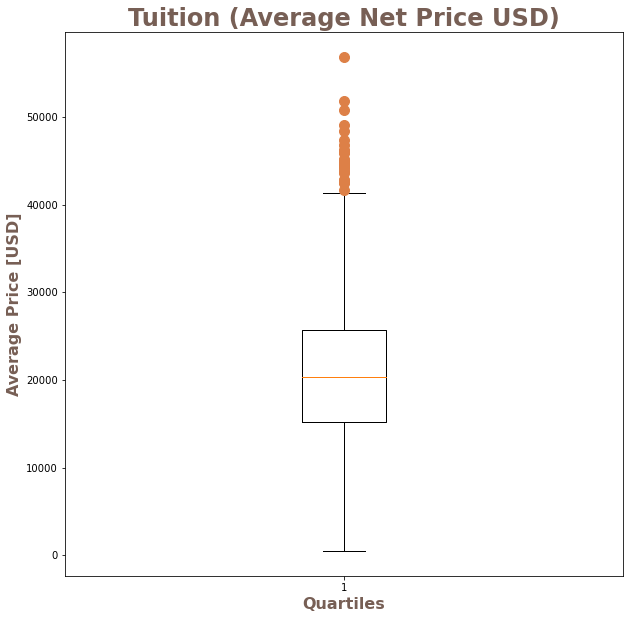

In [34]:
# Build an emblish the box plot containing the four treatments.
fig, ax = plt.subplots(figsize=(10,10))

color_dict = {'flierprops':dict(markeredgecolor = color_rust,                   # set the color of the outlier outline
                                markerfacecolor = color_rust,                   # set the color of the outlier fill
                                marker = 'o',                                   # set the outlier marker shape
                                markersize=10)}

plt.title('Tuition (Average Net Price USD)',                                    # Add a title
            fontsize = 24,
            color=color_brown, 
            fontweight="bold")         

plt.xlabel('Quartiles',                                                         # Add a x-axis descrition
            fontsize = 16,
            color=color_brown, 
            fontweight="bold")

plt.ylabel('Average Price [USD]',                                               # Add a y-axis description
            fontsize = 16, 
            color=color_brown, 
            fontweight="bold")      

ax.boxplot(df['avg_net_price'], **color_dict)

save_fig = os.path.join('.','Output', 'Net_Avg_price_Overall.jpg')              # Prepare to save the figure  
plt.savefig(save_fig, bbox_inches='tight')                                      # Save the figure

### Examination of the Average Net Price by Quartile

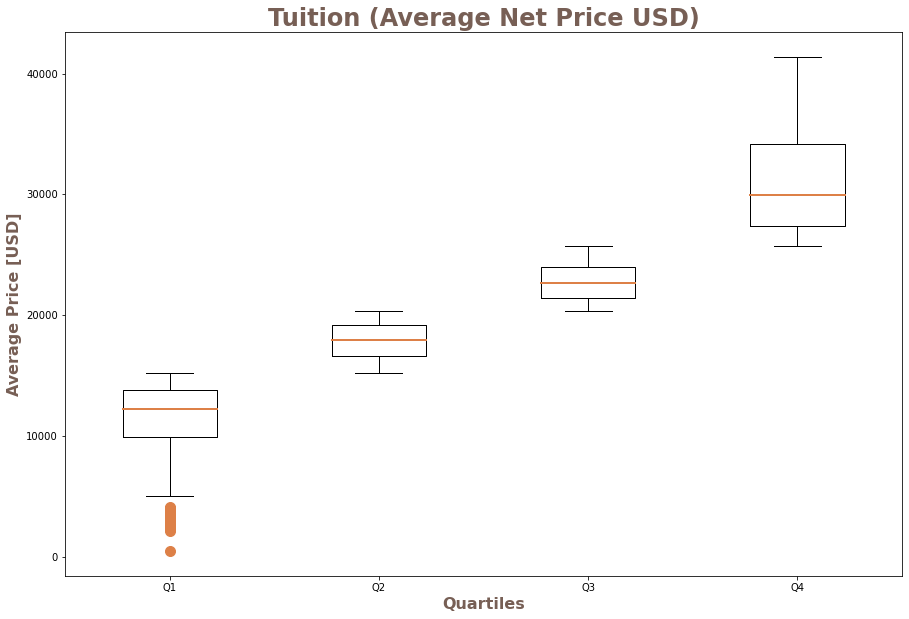

In [35]:
myDic= {'Q1':df['avg_net_price'].loc[df['Avg_Net_Price_Q']== 'Q1'], 
        'Q2':df['avg_net_price'].loc[df['Avg_Net_Price_Q']== 'Q2'], 
        'Q3':df['avg_net_price'].loc[df['Avg_Net_Price_Q']== 'Q3'], 
        'Q4':df['avg_net_price'].loc[df['Avg_Net_Price_Q']== 'Q4']}

# Set up the formating of the outlier marker
color_dict = {'flierprops':dict(markeredgecolor = color_rust,                   # set the color of the outlier outline
                                markerfacecolor = color_rust,                   # set the color of the outlier fill
                                marker = 'o',                                   # set the outlier marker shape
                                markersize=10)}                                 # set the outlier size

medianprops = dict(linestyle='-', linewidth=2, color=color_rust)

# Build an emblish the box plot containing the four treatments.
fig, ax = plt.subplots(figsize=(15,10))

plt.title('Tuition (Average Net Price USD)',                    # Add a title
            fontsize = 24,
            color=color_brown, 
            fontweight="bold")         

plt.xlabel('Quartiles',                           # Add a x-axis descrition
            fontsize = 16,
            color=color_brown, 
            fontweight="bold")

plt.ylabel('Average Price [USD]',                 # Add a y-axis description
            fontsize = 16, 
            color=color_brown, 
            fontweight="bold")      

ax.boxplot(myDic.values(), **color_dict, medianprops=medianprops )
ax.set_xticklabels(myDic.keys());                 # the " ; " at the end suppress the ploting information for the last item added to the chart

save_fig = os.path.join('.','Output', 'Net_Avg_price_by_Quartile.jpg')          # Prepare to save the figure  
plt.savefig(save_fig, bbox_inches='tight')                                      # Save the figure

# Histogram of Average Net Price 
#### For all Schools

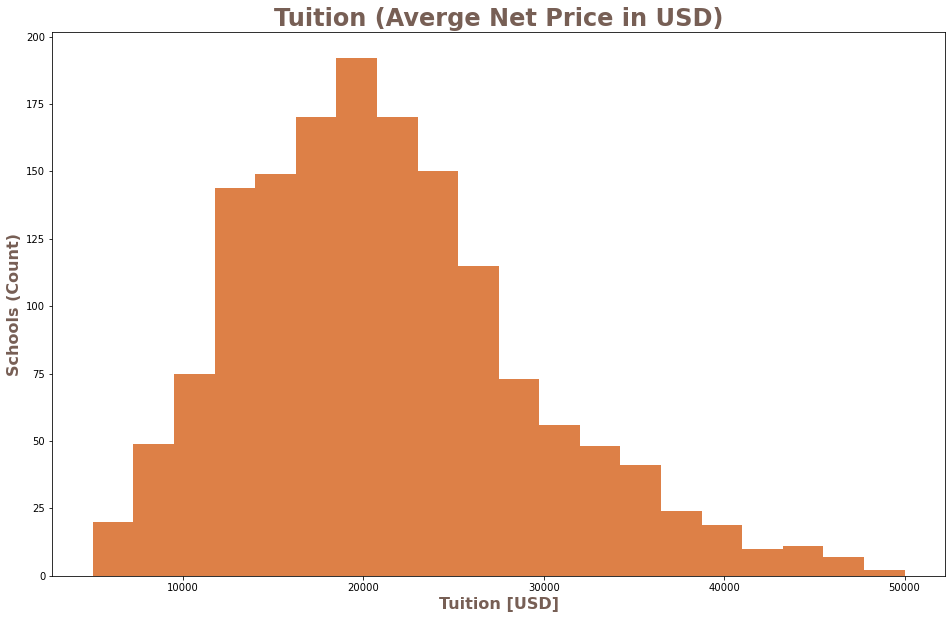

In [36]:

#df.plot(kind='Histogram')
plt.figure(figsize=(16,10)) 

plt.hist(df['avg_net_price'], color=color_rust, bins=20,range=(5000,50000)); 
plt.title('Tuition (Averge Net Price in USD)',                    # Add a title
            fontsize = 24,
            color=color_brown, 
            fontweight="bold")         
plt.ylabel("Schools (Count)",                                               # Add a y-axis description
            fontsize = 16, 
            color=color_brown, 
            fontweight="bold")                              
plt.xlabel("Tuition [USD]",                                                 # Add a x-axis descrition
            fontsize = 16,
            color=color_brown, 
            fontweight="bold")

save_fig = os.path.join('.','Output', 'Avg_Net_Price_Hist.jpg')             # Prepare to save the figure  
plt.savefig(save_fig, bbox_inches='tight')                                  # Save the figure

#### For Q1 Schools

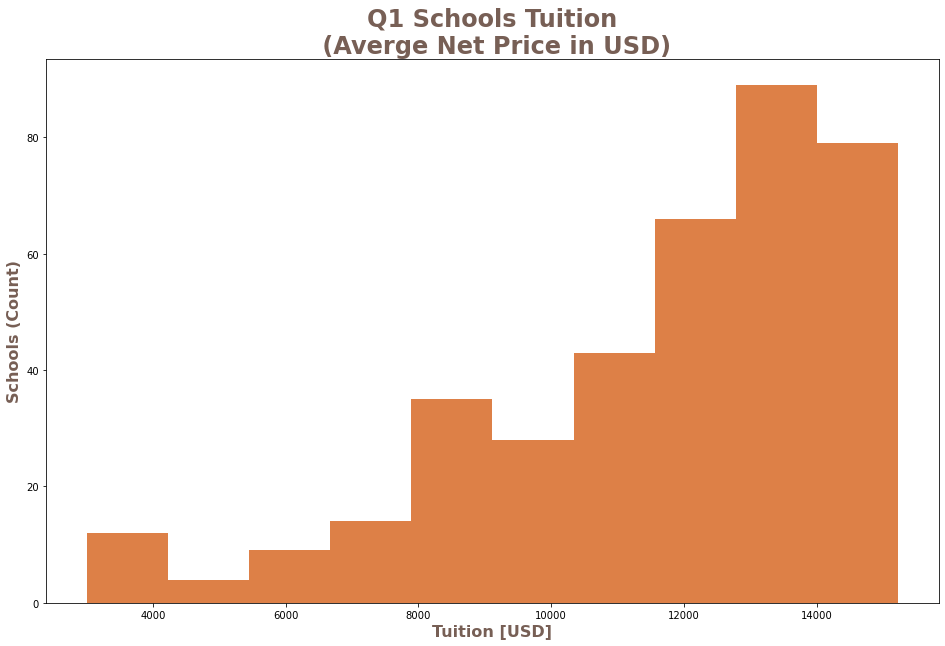

In [37]:
df_Q1 = df.loc[df['Avg_Net_Price_Q']=='Q1']
#df.plot(kind='Histogram')
plt.figure(figsize=(16,10)) 
plt.hist(df_Q1['avg_net_price'],color=color_rust, range=(3000,lowerq)); 
plt.title("Q1 Schools Tuition\n (Averge Net Price in USD)",       # Add a title
           fontsize = 24, 
           color=color_brown, 
           fontweight="bold")         
plt.ylabel("Schools (Count)",                                               # Add a y-axis description
            fontsize = 16, 
            color=color_brown,
            fontweight="bold")                          
plt.xlabel("Tuition [USD]",                                                 # Add x x-axis description
            fontsize = 16, 
            color=color_brown, 
            fontweight="bold")

save_fig = os.path.join('.','Output', 'Q1_Avg_Net_Price_Hist.jpg')      # Prepare to save the figure  
plt.savefig(save_fig, bbox_inches='tight')                              # Save the figure

# Examination of Student Population 
#### Overall view of Student Population

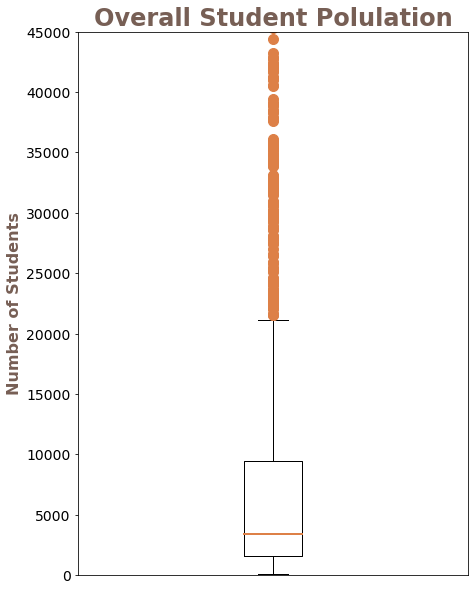

In [38]:
fig, ax = plt.subplots(figsize=(7,10))

df.boxplot("headcount",                     # Boxplot of student count
            grid = False,                       # turn off the grid
            layout=None,                        # not sure what this did
            fontsize = 14,                      # set the font size for the x and y ticks
            ax= ax,                             # put the plot in a matplotlib frame so that I can use the matplotlib formating
            color='black',                      # make the boxes and wiskers black
            medianprops=medianprops,            # control the color and with of the median bar (Values set with the first box plot above)
            **color_dict)                       # set the color dictionary for the title

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.ylim(0,45000)                               # limit the maximum y - there are some very large outliers
ax.set_title('')                                # Supress standard title
plt.suptitle('')                                # Supress standard subtitle

plt.title('Overall Student Polulation',                 # Add a title
            fontsize = 24,
            color=color_brown, 
            fontweight="bold")         
        

plt.ylabel('Number of Students',                # Add a y-axis description
            fontsize = 16, 
            color=color_brown, 
            fontweight="bold");                              


save_fig = os.path.join('.','Output', 'Student_population.jpg')          # Prepare to save the figure  
plt.savefig(save_fig, bbox_inches='tight')                                      # Save the figure

#### Examination of the Student Population by Quartile

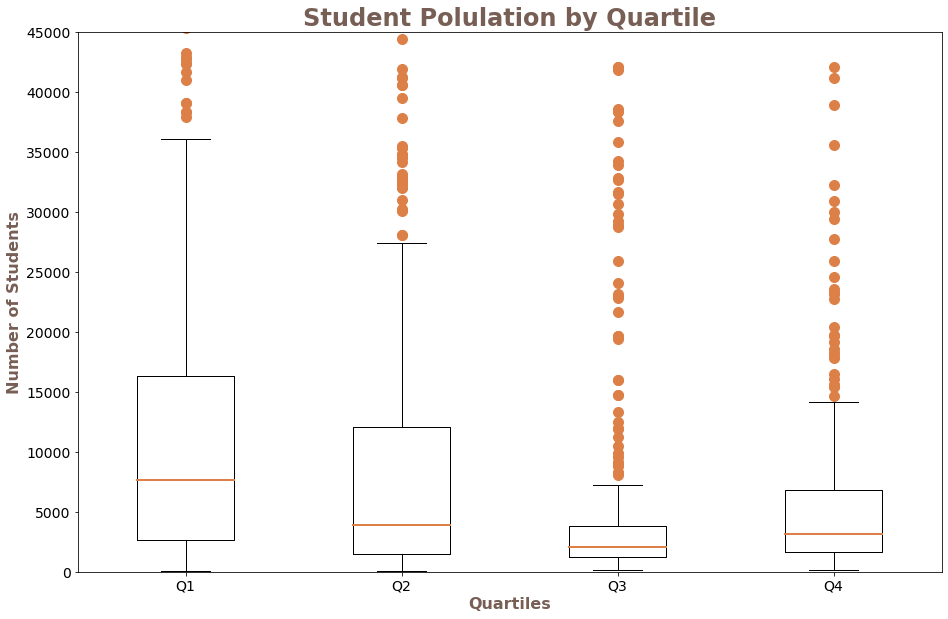

In [39]:
# There is a bug in python or python pandas.  Even if you drop rows out of the dataframe, there existance is not forgotten
# To work around this problem I have saved the df as a CSV and read it back in again. Problem solved.
df_box = df.copy()
df_box.drop(df_box[df_box['Avg_Net_Price_Q']=='Out+'].index, inplace=True)
file_one = os.path.join('.','Output', 'data_and_Q_NOL.csv')
df_box.to_csv(file_one, index=False, header=True)
df_box = pd.read_csv("./Output/data_and_Q_NOL.csv")

fig, ax = plt.subplots(figsize=(15,10))

df_box.boxplot("headcount",                     # Boxplot of student count
            by="Avg_Net_Price_Q",               # broken up by Average Net Price quartiles
            grid = False,                       # turn off the grid
            layout=None,                        # not sure what this did
            fontsize = 14,                      # set the font size for the x and y ticks
            ax= ax,                             # put the plot in a matplotlib frame so that I can use the matplotlib formating
            color='black',                      # make the boxes and wiskers black
            medianprops=medianprops,            # control the color and with of the median bar (Values set with the first box plot above)
            **color_dict)                       # set the color dictionary for the title


plt.ylim(0,45000)                               # limit the maximum y - there are some very large outliers
ax.set_title('')                                # Supress standard title
plt.suptitle('')                                # Supress standard subtitle

plt.title('Student Polulation by Quartile',                 # Add a title
            fontsize = 24,
            color=color_brown, 
            fontweight="bold")         
        

plt.ylabel('Number of Students',                # Add a y-axis description
            fontsize = 16, 
            color=color_brown, 
            fontweight="bold")                              

plt.xlabel('Quartiles',                          # Add a x-axis descrition
            fontsize = 16,
            color=color_brown, 
            fontweight="bold");


save_fig = os.path.join('.','Output', 'Student_Population_by_Quartile.jpg')          # Prepare to save the figure  
plt.savefig(save_fig, bbox_inches='tight')                                      # Save the figure

# Examination of Student Graduation Rates
#### Graduatioin Rate at the 150% by Quartile

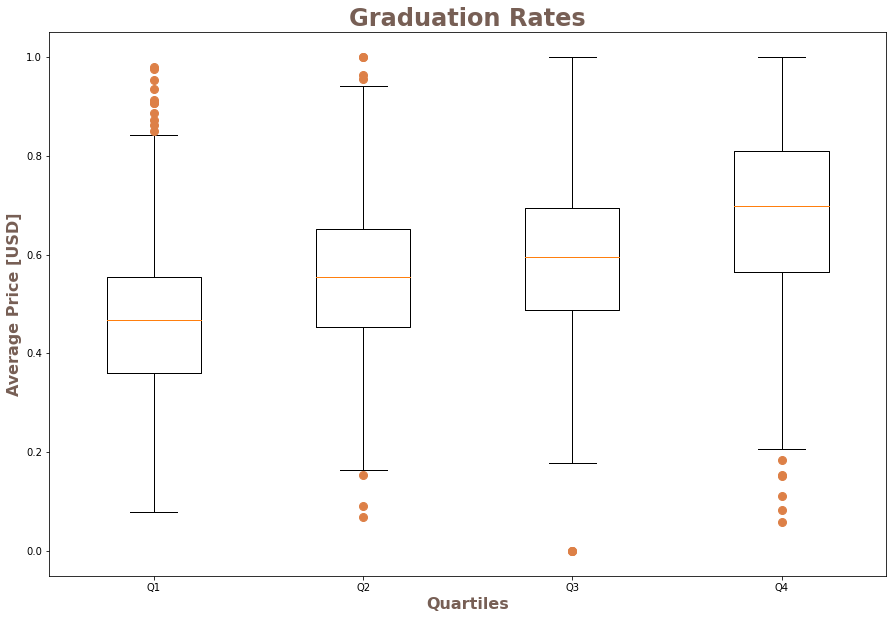

In [40]:
myDic= {'Q1':df['comp_rate_150'].loc[df['Avg_Net_Price_Q']== 'Q1'], 
        'Q2':df['comp_rate_150'].loc[df['Avg_Net_Price_Q']== 'Q2'], 
        'Q3':df['comp_rate_150'].loc[df['Avg_Net_Price_Q']== 'Q3'], 
        'Q4':df['comp_rate_150'].loc[df['Avg_Net_Price_Q']== 'Q4']}

# Set up the formating of the outlier marker
color_dict = {'flierprops':dict(markeredgecolor=color_rust,                          # set the color of the outlier outline
                                markerfacecolor = color_rust,                        # set the color of the outlier fill
                                marker = 'o',                                   # set the outlier marker shape
                                markersize=8)}                                 # set the outlier size


# Build an emblish the box plot containing the four treatments.
fig, ax = plt.subplots(figsize=(15,10))

plt.title('Graduation Rates',                    # Add a title
            fontsize = 24,
            color=color_brown, 
            fontweight="bold")         

plt.ylabel('Average Price [USD]',                                               # Add a y-axis description
            fontsize = 16, 
            color=color_brown, 
            fontweight="bold")                              

plt.xlabel('Quartiles',                                                 # Add a x-axis descrition
            fontsize = 16,
            color=color_brown, 
            fontweight="bold")


ax.boxplot(myDic.values(), **color_dict)
ax.set_xticklabels(myDic.keys());               # the " ; " at the end suppress the ploting information for the last item added to the chart

save_fig = os.path.join('.','Output', 'Graduation_Rates_150_by_Quartile.jpg')                  # Prepare to save the figure  
plt.savefig(save_fig, bbox_inches='tight')                                      # Save the figure